In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def prepare_df(df,date_feature, group_array,start_date,end_date):

    # Convert to datetime format
    df[date_feature] = pd.to_datetime(df[date_feature])

    # Select data from dates according to start_date and end_date
    df = df[df[date_feature]>= pd.to_datetime(start_date)]
    df = df[df[date_feature]<= pd.to_datetime(end_date)]

    # Group according to categories
    df_grp = df.groupby(group_array).count();

    # Unpack the indices into columns
    df_grp = df_grp.xs(date_feature, axis=1, drop_level=True)
    df_grp = df_grp.unstack().fillna(0)
  
    # Return the dataframe
    return df_grp

def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new

In [52]:
source_csv = '/home/work/GitHub/data/teacher_timeseries.csv'
source_user = '/home/work/GitHub/data/user_info.csv'

df = pd.read_csv(source_csv)
df_user = pd.read_csv(source_user)

df_new.head()

,event_type,date_of_event,registration_date
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,q_lvl_4_cor,2015-12-09 22:06:35.997,2015-12-09 22:20:36.767
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,q_lvl_4,2015-12-09 22:07:28.978,2015-12-09 22:20:36.767
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,view_hint,2015-12-09 22:07:37.847,2015-12-09 22:20:36.767
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,view_hint,2015-12-09 22:07:43.401,2015-12-09 22:20:36.767
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,view_hint,2015-12-09 22:07:46.617,2015-12-09 22:20:36.767


In [40]:
df_user.head()

,Unnamed: 0,id,role,registration_date,last_seen
0,0,d94c077ad88fc2b7a1204ba16c30f93961d86ededecbb4...,STUDENT,2015-11-30 09:28:47.748,2016-10-10 14:00:40.084
1,1,1ef02c359b5b66b584da8d46d1f790f509eeb55b80a908...,STUDENT,2015-10-21 15:51:11.947,2016-04-11 21:24:06.927
2,2,eed0d25033826f9786fc61daef41f9f6c0046248254e3c...,STUDENT,2015-12-09 12:58:28.449,2016-07-01 19:20:14.440
3,3,5937dd6ec7778da3dc7cc63303439bcc6a622da83fdf4a...,STUDENT,2015-11-30 09:39:07.939,2016-06-22 15:00:29.981
4,4,68a983c9bfca031c77b2159cf651a624a893a02cc79bdd...,STUDENT,2015-04-14 21:58:24.310,2015-04-14 21:58:24.765


In [53]:
# Remove 'Unnamed' columns
df = df.drop('Unnamed: 0',axis=1)
df_user = df_user.drop('Unnamed: 0',axis=1)

# Join user data to the main dataframe
df_new = df.set_index('user_id').join(df_user.set_index('id')['registration_date'])

# Discretise (set time window)
dt = 30*24*3600
df_new['event_leg'] = np.floor((pd.to_datetime(df_new['date_of_event']) - pd.to_datetime(df_new['registration_date'])).dt.total_seconds()/dt)

# Group and create a new multi index dataframe  
start_date = '2014-08-01'
end_date = '2017-05-01'

df_grp = prepare_df(df_new.drop('registration_date').reset_index(),'date_of_event',['index','event_leg','event_type'],start_date,end_date)
df_grp.head()

event_type                                                    add_assig  \
index                                              event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0             0.0   
                                                    0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0             0.0   
                                                    0.0             0.0   

event_type                                                    add_custom_assig  \
index                                              event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                    0.0   
                                                    0.0                    0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                    0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0                    0.0   
                                                    0.0                    0.0   

event_type                                                    add_user  \
index                                              event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0            0.0   
                                                    0.0            0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0            0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0            0.0   
                                                    0.0            0.0   

event_type                                                    create_group  \
index                                              event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                0.0   
                                                    0.0                0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0                0.0   
                                                    0.0                0.0   

event_type                                                    play_video  \
index                                              event_leg               
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0              0.0   
                                                    0.0              0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0              0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0              0.0   
                                                    0.0              8.0   

event_type                                                    q_lvl_0  \
index                                              event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0           0.0   
                                                    0.0           0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0           0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0           0.0   
                                                    0.0           0.0   

event_type                                                    q_lvl_0_cor  \
index                                              event_leg                
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0               0.0   
                                                    0.0               0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0               0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... -1.0               0.0   
                                                    0.0               0.0   

event_type                                                    q_lvl_1  \
index                                              event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0           0.0   
                             

In [76]:
## Add the events of event_leg -1 to 0

# Change the -1 event to 0
df_new = df_grp[df_grp.index.get_level_values(1)<0].reset_index()
df_new['event_leg'] = 0

# Add the dataframes together
df = df_grp.add(df_new.set_index(['index','event_leg']),fill_value=0)

# Removing event_leg = -1
df = df[df.index.get_level_values(1)>= 0]

# Save the csv
df.to_csv('/home/work/GitHub/data/teacher_churn/edit_teacher_timeseries.csv')

df.head()


event_type                                                    add_assig  \
index                                              event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0              0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0              0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
                                                   4.0              0.0   

event_type                                                    add_custom_assig  \
index                                              event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                     0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                     0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   4.0                     0.0   

event_type                                                    add_user  \
index                                              event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
                                                   4.0             0.0   

event_type                                                    create_group  \
index                                              event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                 0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                 0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   4.0                 0.0   

event_type                                                    play_video  \
index                                              event_leg               
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0               0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0               0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0               8.0   
                                                   1.0               1.0   
                                                   4.0               4.0   

event_type                                                    q_lvl_0  \
index                                              event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0            0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0            0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0            0.0   
                                                   1.0            0.0   
                                                   4.0            4.0   

event_type                                                    q_lvl_0_cor  \
index                                              event_leg                
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                0.0   
                                                   1.0                0.0   
                                                   4.0               12.0   

event_type                                                    q_lvl_1  \
index                                              event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0            0.0   
0018d184ff3b1f2336ebeac5646d1

In [72]:
last_month = 0;

# Find users that have churned
plot_churn = df.reset_index().groupby('index')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

,event_type,add_assig,add_custom_assig,add_user,create_group,play_video,q_lvl_0,q_lvl_0_cor,q_lvl_1,q_lvl_1_cor,q_lvl_2,...,q_lvl_3_cor,q_lvl_4,q_lvl_4_cor,q_lvl_5,q_lvl_5_cor,q_lvl_6,q_lvl_6_cor,view_assig_prog,view_concept,view_hint
index,event_leg,,,,,,,,,,,,,,,,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,17.0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,0.0,1.0,0.0,0.0,1.0,1.0,4.0,4.0,5.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
006a28f9870a964816db69d1bb9dda8be0cac871af2fdfc3c303179023a2e299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,0.0,3.0,10.0,1.0,0.0,26.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c592c6f1fe2c5b7b0028,0.0,0.0,8.0,23.0,2.0,0.0,4.0,2.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,1.0,8.0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0


In [73]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['index','event_leg']).sum(),[0,1],'append')

df_lm_new.head()

,add_assig_0,add_custom_assig_0,add_user_0,create_group_0,play_video_0,q_lvl_0_0,q_lvl_0_cor_0,q_lvl_1_0,q_lvl_1_cor_0,q_lvl_2_0,...,q_lvl_3_cor_0,q_lvl_4_0,q_lvl_4_cor_0,q_lvl_5_0,q_lvl_5_cor_0,q_lvl_6_0,q_lvl_6_cor_0,view_assig_prog_0,view_concept_0,view_hint_0
index,,,,,,,,,,,,,,,,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,17.0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,1.0,0.0,0.0,1.0,1.0,4.0,4.0,5.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


(array([ 1260.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1478.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

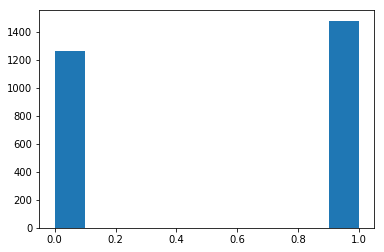

In [74]:
# Check class distribution
plt.hist(label)